In [1]:
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def latex_label(text):
    """
    Converts regular text to a LaTeX-compatible label, handling LaTeX math mode correctly.
    """
    # Split text into math ($...$) and non-math segments
    parts = re.split(r'(\$.+?\$)', text)
    formatted_parts = []

    for part in parts:
        if part.startswith('$') and part.endswith('$'):
            # It's a math mode segment, add it as is
            formatted_parts.append(part)
        else:
            # Replace spaces with ~ and wrap non-math text with \mathrm{}
            clean_fragment = part.replace(' ', '~')
            if clean_fragment:
                latex_command = r"\mathrm{" + clean_fragment + "}"
                formatted_parts.append(f'${latex_command}$')
                # formatted_parts.append(f'${r"\mathrm{" + clean_fragment + "}"}$')

    return ''.join(formatted_parts)

In [3]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [4]:
def plot_mpc_trajectory(ts, z_ref, z_mpc, z_true, u_mpc, N, plot_controls=True, topdown=False):
    """
    Plot the MPC trajectory for 2D or 3D data.
    """
    # Determine the dimension (2D or 3D)
    dim = z_ref.shape[1]

    # Set up the plotting environment
    if plot_controls:
        if dim == 2:
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        else:
            fig = plt.figure(figsize=(12, 5))
            ax = [fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2)]
    else:
        if dim == 2:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
            ax = [ax]
        else:
            fig = plt.figure(figsize=(6, 5))
            ax = [fig.add_subplot(1, 1, 1, projection='3d')]

    # Plot the MPC trajectories
    for t_idx in range(len(ts) - 2 * N):
        if dim == 2:
            ax[0].plot(z_mpc[t_idx, :, 0], z_mpc[t_idx, :, 1], '--*', color='k', markersize=3,
                       label=latex_label('MPC') if t_idx == 0 else None)
        else:
            ax[0].plot3D(z_mpc[t_idx, :, 0], z_mpc[t_idx, :, 1], z_mpc[t_idx, :, 2], '--*', color='k', markersize=3,
                         label=latex_label('MPC') if t_idx == 0 else None)

    # Plot the true trajectory, start point, and reference
    if dim == 2:
        ax[0].plot(z_true[:-N, 0], z_true[:-N, 1], '-o', label=latex_label('True'), markersize=3)
        ax[0].plot(z_true[0, 0], z_true[0, 1], 'ro', label=latex_label('Start'), markersize=6)
        ax[0].plot(z_ref[:-N, 0], z_ref[:-N, 1], 'y--', label=latex_label('Reference'))
        ax[0].set_xlabel(latex_label('X [m]'))
        ax[0].set_ylabel(latex_label('Y [m]'))
        ax[0].axis('equal')
    else:
        ax[0].plot3D(z_true[:-N, 0], z_true[:-N, 1], z_true[:-N, 2], '-o', label=latex_label('True'), markersize=3)
        ax[0].scatter(z_true[0, 0], z_true[0, 1], z_true[0, 2], color='r', label=latex_label('Start'), s=36)
        ax[0].plot3D(z_ref[:-N, 0], z_ref[:-N, 1], z_ref[:-N, 2], 'y--', label=latex_label('Reference'))
        ax[0].set_xlabel(latex_label('X [m]'))
        ax[0].set_ylabel(latex_label('Y [m]'))
        ax[0].set_zlabel(latex_label('Z [m]'))
        ax[0].set_box_aspect([1, 1, 1])
        if topdown:
            ax[0].view_init(elev=180, azim=-90, roll=-0)
        else:
            ax[0].view_init(elev=115, azim=-115, roll=-25)
        set_axes_equal(ax[0])
    ax[0].legend()

    # Plot the control inputs
    if plot_controls:
        for u_idx in range(u_mpc.shape[-1]):
            # Determine the line style based on the index
            if u_idx == 0 or u_idx == 5:
                linestyle = '-'  # Full line for 1 and 6
            elif u_idx == 1 or u_idx == 3:
                linestyle = '--'  # Dashed line for 2 and 4
            elif u_idx == 2 or u_idx == 4:
                linestyle = '-.'  # Double dashed line for 3 and 5
        
            ax[1].plot(ts, u_mpc[:, 0, u_idx], label=latex_label(f'u_{u_idx+1}(t)'), linestyle=linestyle)
        # for u_idx in range(u_mpc.shape[-1]):
        #     ax[1].plot(ts, u_mpc[:, 0, u_idx], label=latex_label(f'u_{u_idx+1}(t)'))
        ax[1].set_xlabel(latex_label('t [s]'))
        ax[1].set_ylabel(latex_label('U'))
        ax[1].legend()

    plt.tight_layout()

In [5]:
def generate_ref_trajectory(T, dt, traj_type, size, dim=2):
    """
    Generate a 3D reference trajectory for the system to track.
    """
    t = np.linspace(0, T, int(T/dt))
    z_ref = np.zeros((len(t), dim))

    # NOTE: y is vertically up here
    if dim==2:
        if traj_type == 'circle':
            z_ref[:, 0] = size * (np.cos(2 * np.pi / T * t) - 1)
            z_ref[:, 1] = size * np.sin(2 * np.pi / T * t)
        elif traj_type == 'figure_eight':
            z_ref[:, 0] = size * np.sin(2 * np.pi / T * t)
            z_ref[:, 1] = size * np.sin(4 * np.pi / T * t)
        elif traj_type == 'periodic_line':
            m = -1
            z_ref[:, 0] = size * np.sin(2 * np.pi / T * t)
            z_ref[:, 1] = m * size * np.sin(2 * np.pi / T * t)
        elif traj_type == 'arc':
            m = 1
            l_trunk = 0.35
            R = l_trunk / 2
            z_ref[:, 0] = size * np.sin(2 * np.pi / T * t)
            z_ref[:, 1] = m * size * np.sin(2 * np.pi / T * t)
        else:
            raise ValueError('Invalid trajectory type: ' + traj_type + '. Valid options are: "circle" or "figure_eight".')
    elif dim ==3:
        if traj_type == 'circle':
            z_ref[:, 0] = size * (np.cos(2 * np.pi / T * t) - 1)
            z_ref[:, 1] = size / 2 * np.ones_like(t)
            z_ref[:, 2] = size * np.sin(2 * np.pi / T * t)
        elif traj_type == 'figure_eight':
            z_ref[:, 0] = size * np.sin(2 * np.pi / T * t)
            z_ref[:, 1] = 0 * np.ones_like(t)
            z_ref[:, 2] = size * np.sin(4 * np.pi / T * t)
        elif traj_type == 'periodic_line':
            m = -1
            z_ref[:, 0] = size * np.sin(2 * np.pi / T * t)
            z_ref[:, 1] = np.zeros_like(t)
            z_ref[:, 2] = m * size * np.sin(2 * np.pi / T * t)
        elif traj_type == 'arc':
            m = 1
            l_trunk = 0.35
            R = l_trunk / 2
            z_ref[:, 0] = size * np.sin(2 * np.pi / T * t)
            z_ref[:, 2] = m * size * np.sin(2 * np.pi / T * t)
            z_ref[:, 1] = R - np.sqrt(R**2 - z_ref[:, 0]**2 - z_ref[:, 0]**2)
        else:
            raise ValueError('Invalid trajectory type: ' + traj_type + '. Valid options are: "circle" or "figure_eight".')
    return z_ref, t

In [6]:
# Generate reference trajectory (check that it's the same as used in mpc_initializer_node.py)
z_ref, t = generate_ref_trajectory(10, 0.01, 'circle', 0.05, dim=3)

In [7]:
N = 6
n_x = 5
n_z = 3
n_u = 6
# mpc_test_data = pd.read_csv(f'../data/trajectories/test_mpc/mpc_U04-dU0-Q50-Qzf100-R0001-0005-001-N{N}-4D-small_figure_eight.csv')
mpc_test_data = pd.read_csv(f'../data/trajectories/test_mpc/mpc_Rdu005.csv')
topt_pd, xopt_pd, uopt_pd, zopt_pd = mpc_test_data['topt'], mpc_test_data['xopt'], mpc_test_data['uopt'], mpc_test_data['zopt']
num_samples = len(topt_pd)
topt_np = np.zeros((num_samples, N+1))
xopt_np = np.zeros((num_samples, N+1, n_x))
uopt_np = np.zeros((num_samples, N, n_u))
zopt_np = np.zeros((num_samples, N+1, n_z))
for sample_idx in range(num_samples):
    topt_list = ast.literal_eval(topt_pd[sample_idx].strip('"'))
    topt_np[sample_idx, :] = topt_list
    xopt_list = ast.literal_eval(xopt_pd[sample_idx].strip('"'))
    xopt_np[sample_idx, :] = np.array(xopt_list).reshape(-1, n_x)
    uopt_list = ast.literal_eval(uopt_pd[sample_idx].strip('"'))
    uopt_np[sample_idx, :] = np.array(uopt_list).reshape(-1, n_u)
    zopt_list = ast.literal_eval(zopt_pd[sample_idx].strip('"'))
    zopt_np[sample_idx, :] = np.array(zopt_list).reshape(-1, n_z)

In [ ]:
N = 6
n_x = 5
n_z = 3
n_u = 6
mpc_cl_data = pd.read_csv(f'../data/trajectories/closed_loop/mpc_Rdu005.csv')
topt_pd, xopt_pd, uopt_pd, zopt_pd = mpc_test_data['topt'], mpc_test_data['xopt'], mpc_test_data['uopt'], mpc_test_data['zopt']
num_samples = len(topt_pd)
topt_np = np.zeros((num_samples, N+1))
xopt_np = np.zeros((num_samples, N+1, n_x))
uopt_np = np.zeros((num_samples, N, n_u))
zopt_np = np.zeros((num_samples, N+1, n_z))
for sample_idx in range(num_samples):
    topt_list = ast.literal_eval(topt_pd[sample_idx].strip('"'))
    topt_np[sample_idx, :] = topt_list
    xopt_list = ast.literal_eval(xopt_pd[sample_idx].strip('"'))
    xopt_np[sample_idx, :] = np.array(xopt_list).reshape(-1, n_x)
    uopt_list = ast.literal_eval(uopt_pd[sample_idx].strip('"'))
    uopt_np[sample_idx, :] = np.array(uopt_list).reshape(-1, n_u)
    zopt_list = ast.literal_eval(zopt_pd[sample_idx].strip('"'))
    zopt_np[sample_idx, :] = np.array(zopt_list).reshape(-1, n_z)

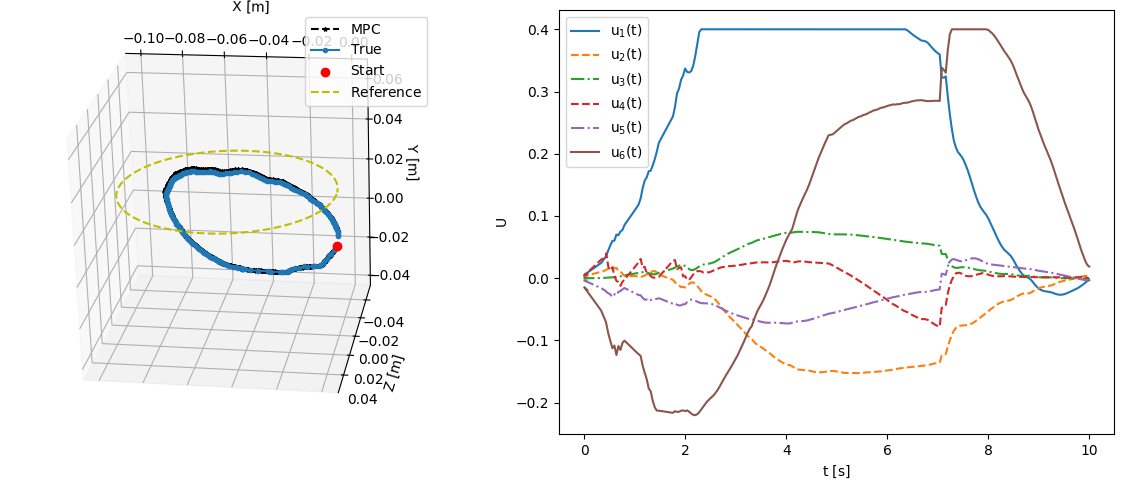

In [9]:
# %matplotlib widget
plot_mpc_trajectory(topt_np[:, 0], z_ref[:], zopt_np[:], zopt_np[:, 0, :], uopt_np, N, plot_controls=True, topdown=False)

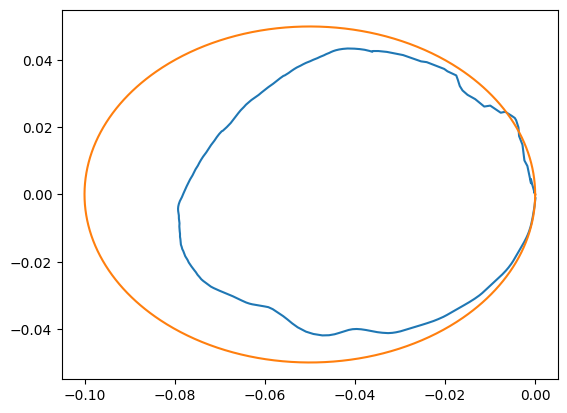

In [14]:
# 2D version
fig = plt.figure()
plt.plot(zopt_np[:, 0, 0], zopt_np[:, 0, -1])
plt.plot(z_ref[:, 0], z_ref[:, -1])